In [1]:
import numpy as np
import pandas as pd
import random
import os
import time
import pickle
from pathlib import Path
import gc

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
#import xgboost as xgb
#import catboost as ctb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

https://www.kaggle.com/mlanhenke/tps-10-single-lgbm-model/notebook

ver6

# Parameters

In [2]:
target = 'target'

DEBUG = False

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 2017
    CVSEED = 2017
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    #N_ITERS = 2
else:
    N_SPLITS = 5
    N_ESTIMATORS = 20000
    EARLY_STOPPING_ROUNDS = 300
    VERBOSE = 1000
    SEED = 2017
    CVSEED = 2017
    #N_ITERS = 10

In [3]:
def set_seed(seed=2017):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Datasets

In [4]:
INPUT = Path("../input/tabular-playground-series-oct-2021")

train = pd.read_csv(INPUT / "train.csv")
test = pd.read_csv(INPUT / "test.csv")
submission = pd.read_csv(INPUT / "sample_submission.csv")

In [5]:
train = train[train.columns[1:]]
test = test[test.columns[1:]]

# Preprocessing

In [6]:
features = [col for col in train.columns if 'f' in col]

In [7]:
disc_feat = [col for col in train[features].columns if train[col].dtype == 'int64']

In [8]:
def get_row_stats(df):
    df['r_sum'] = df[disc_feat].mean(axis=1)
    return df

train = get_row_stats(train)
test = get_row_stats(test)

features = features + ['r_sum']

In [9]:
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [10]:
train = reduce_memory_usage(train)
test = reduce_memory_usage(test)

Mem. usage decreased to 503.54 Mb (77.0% reduction)
Mem. usage decreased to 251.29 Mb (77.0% reduction)


In [11]:
test[features]

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f276,f277,f278,f279,f280,f281,f282,f283,f284,r_sum
0,0.178223,0.435547,0.010231,0.202026,0.390137,0.324219,0.221680,0.738770,0.582520,0.343750,...,0,0,0,0,0,1,1,1,0,0.399902
1,0.181274,0.476562,0.022415,0.283203,0.598145,0.349609,0.283447,0.721680,0.269043,0.208374,...,0,0,0,0,0,0,0,0,0,0.288818
2,0.159668,0.451172,0.259766,0.365234,0.594727,0.413574,0.249268,0.642578,0.411133,0.246948,...,0,0,0,0,0,1,0,0,0,0.422119
3,0.182373,0.520996,0.095337,0.327637,0.741699,0.358643,0.270020,0.601562,0.297852,0.252930,...,0,0,0,0,1,1,0,0,0,0.355469
4,0.229370,0.336426,0.023514,0.301025,0.668945,0.481689,0.545898,0.667969,0.545898,0.202759,...,0,0,0,1,0,0,1,0,0,0.355469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0.185425,0.525391,0.014946,0.203979,0.499023,0.431885,0.470459,0.731445,0.452148,0.211182,...,0,0,0,0,0,1,0,0,0,0.244385
499996,0.183228,0.553223,0.008057,0.280762,0.636719,0.478027,0.450439,0.582520,0.517090,0.225098,...,0,0,0,0,0,0,1,0,0,0.333252
499997,0.184692,0.533691,0.011215,0.201294,0.720703,0.472900,0.427490,0.589355,0.243896,0.413086,...,1,0,0,0,0,0,0,0,0,0.377686
499998,0.227783,0.513184,0.178589,0.313721,0.665527,0.401367,0.183350,0.708008,0.575195,0.152832,...,0,0,0,0,0,1,0,0,0,0.155518


In [12]:
train[target]

0         1
1         1
2         1
3         1
4         1
         ..
999995    1
999996    0
999997    0
999998    1
999999    0
Name: target, Length: 1000000, dtype: int8

# LGB

In [13]:
lgb_params = {
     'objective': 'binary',
     'n_estimators':N_ESTIMATORS,
     #'importance_type': 'gain',
     #'metric':'auc',
     #'boosting_type': 'gbdt',
     'n_jobs' : -1,
     
        
    'learning_rate':  0.01, 
    'min_child_weight': 256,
    'min_child_samples': 20, 
    'reg_alpha': 10, 
    'reg_lambda': 0.1, 
    'subsample': 0.6, 
    'subsample_freq': 1, 
    'colsample_bytree': 0.4,
}

In [14]:
lgb_oof = np.zeros(train.shape[0])
lgb_pred = np.zeros(test.shape[0])
lgb_importances = pd.DataFrame()

X_test = test[features]
del test
gc.collect()


kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=CVSEED)
seed_list=[SEED+4]

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=train[features], y=train[target])):
    print(f"===== fold {fold} =====")
    if fold <12:
        
        X_train = train[features].iloc[trn_idx]
        y_train = train[target].iloc[trn_idx]
        X_valid = train[features].iloc[val_idx]
        y_valid = train[target].iloc[val_idx]
        


        start = time.time()
        for inseed in seed_list:
            lgb_params['random_state'] = inseed

            pre_model = lgb.LGBMClassifier(**lgb_params)
            pre_model.fit(
                X_train, 
                y_train,
                eval_set=[(X_valid, y_valid)],
                eval_metric='auc',
                categorical_feature= disc_feat,
                early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                verbose=VERBOSE,
            )

            lgb_params2 = lgb_params.copy()
            lgb_params2['reg_lambda'] *= 0.9
            lgb_params2['reg_alpha'] *= 0.9
            lgb_params2['learning_rate'] *= 0.1
            model = lgb.LGBMClassifier(**lgb_params2)
            model.fit(
                    X_train, y_train,
                    eval_set=[(X_valid, y_valid)],
                    eval_metric='auc',
                    categorical_feature= disc_feat,
                    early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                    verbose=VERBOSE,
                    init_model=pre_model
            )    

            with open(f"lgb_model{fold}_seed{inseed}.pkl", 'wb') as f:
                pickle.dump(model, f)

            fi_tmp = pd.DataFrame()
            fi_tmp['feature'] = X_train.columns
            fi_tmp['importance'] = model.feature_importances_
            fi_tmp['fold'] = fold
            fi_tmp['seed'] = inseed
            lgb_importances = lgb_importances.append(fi_tmp)

            lgb_oof[val_idx] += model.predict_proba(X_valid)[:,-1] / len(seed_list)
            lgb_pred += model.predict_proba(X_test)[:,-1] / len(seed_list)
            
            del pre_model
            del model
            gc.collect()


        elapsed = time.time() - start
        auc = roc_auc_score(y_valid, lgb_oof[val_idx])
        print(f"fold {fold} - lgb auc: {auc:.6f}, elapsed time: {elapsed:.2f}sec\n")
        
        del X_train
        del y_train
        del X_valid
        del y_valid
        gc.collect()


del X_test
gc.collect()

lgb_pred /= N_SPLITS
print(f"oof lgb_auc = {roc_auc_score(train[target], lgb_oof)}")

np.save("lgb_oof.npy", lgb_oof)
np.save("lgb_pred.npy", lgb_pred)

===== fold 0 =====
Training until validation scores don't improve for 300 rounds
[1000]	valid_0's auc: 0.849108	valid_0's binary_logloss: 0.482017
[2000]	valid_0's auc: 0.853999	valid_0's binary_logloss: 0.472304
[3000]	valid_0's auc: 0.855565	valid_0's binary_logloss: 0.468902
[4000]	valid_0's auc: 0.856153	valid_0's binary_logloss: 0.467454
[5000]	valid_0's auc: 0.856335	valid_0's binary_logloss: 0.466903
[6000]	valid_0's auc: 0.856358	valid_0's binary_logloss: 0.466721
Early stopping, best iteration is:
[5760]	valid_0's auc: 0.856374	valid_0's binary_logloss: 0.466723
Training until validation scores don't improve for 300 rounds
[6000]	valid_0's auc: 0.856374	valid_0's binary_logloss: 0.46672
[7000]	valid_0's auc: 0.856377	valid_0's binary_logloss: 0.466705
[8000]	valid_0's auc: 0.856379	valid_0's binary_logloss: 0.466691
Early stopping, best iteration is:
[7951]	valid_0's auc: 0.856379	valid_0's binary_logloss: 0.466691
fold 0 - lgb auc: 0.856379, elapsed time: 3746.21sec

===== fo

# OOF predictions

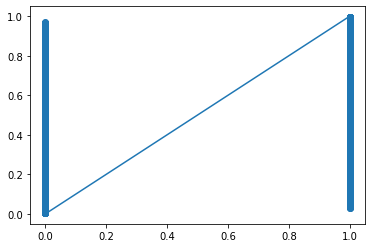

In [15]:
plt.plot(train[target], train[target])
plt.scatter(train[target], lgb_oof)

In [16]:
del train
del lgb_oof
gc.collect()

20

# Features importances

Text(0.5, 1.0, 'LGB feature importances')

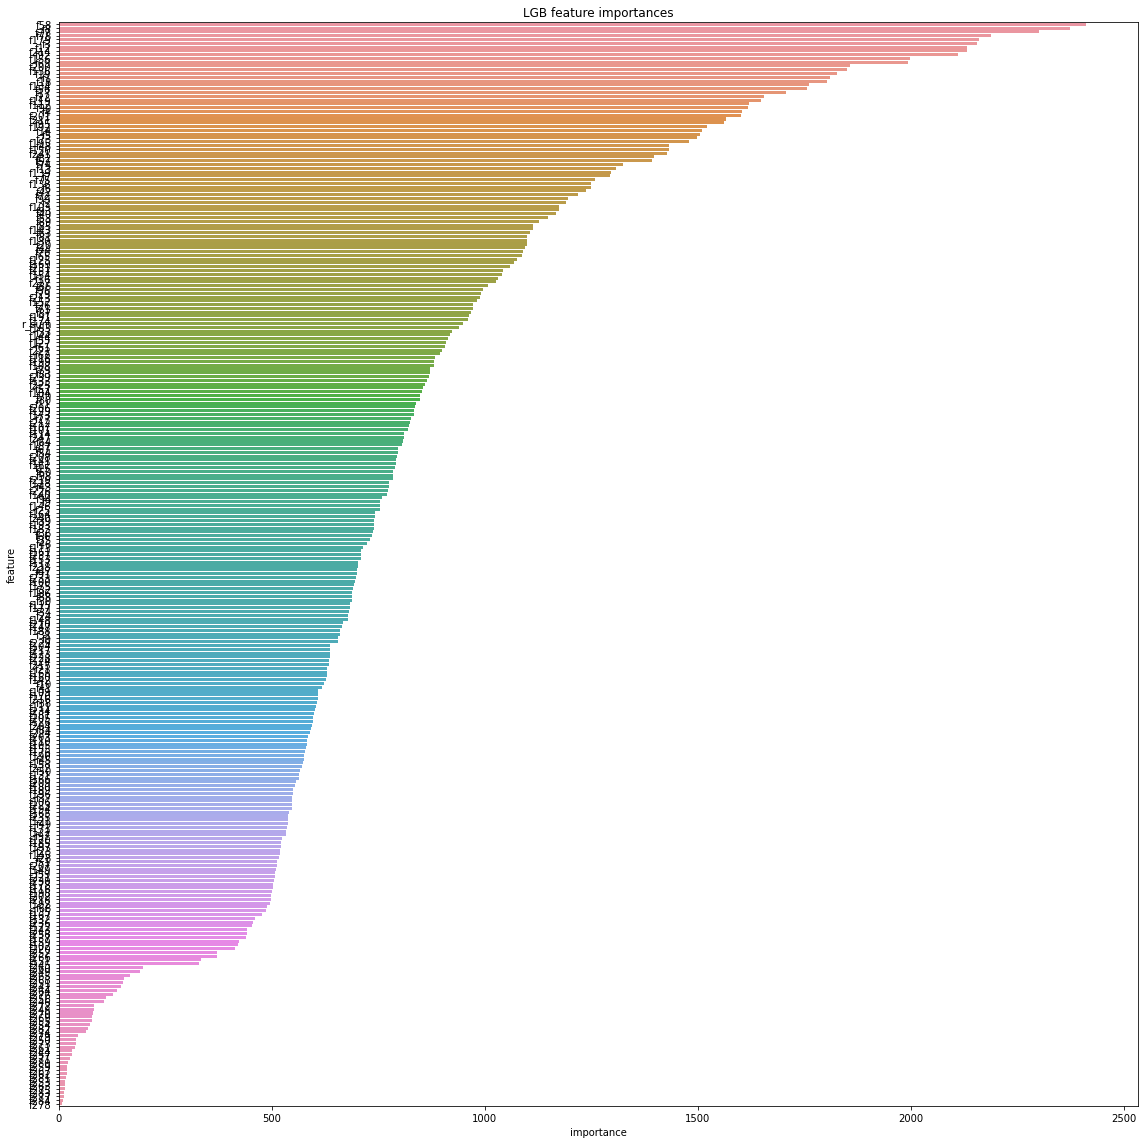

In [17]:
order = list(lgb_importances.groupby('feature').mean().sort_values('importance', ascending=False).index)

fig = plt.figure(figsize=(16, 16), tight_layout=True)
sns.barplot(x="importance", y="feature", data=lgb_importances.groupby('feature').mean().reset_index(), order=order)
plt.title("LGB feature importances")

# Submission

In [18]:
submission[target] = lgb_pred
submission.to_csv("submission.csv", index=False)

submission

,id,target
0,1000000,0.726242
1,1000001,0.245428
2,1000002,0.910781
3,1000003,0.830312
4,1000004,0.269478
...,...,...
499995,1499995,0.975618
499996,1499996,0.841009
499997,1499997,0.284486
499998,1499998,0.493857


# Log

seeds

2017 ver3
2018 ver4
2019 ver5
2020 ver6
2021 ver7